### 피부 추출 (Face Skin Segmentation) 
    
    최초 작성일 : 20/02/28
    작성자 : 양희승
    
    작성내용 : 얼굴에서 피부를 제외한 부분을 제거하는 과정

    수정내용 :
        20/02/29
            코드 수정 
                피부 검출 방식 두가지로 변경
                피부 검출1 -> 색상 범위 (H < 14) -> (H < 25)  수정
                
            코드 추가
                비율 가장 높은 것과 가장 낮은 것 제거
                사진으로 저장
            

In [1]:
import cv2

# !pip install pyimagesearch
# from pyimagesearch import imutils
import numpy as np
import argparse
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

     2007 년 Kakumanu 라는 사람이 Pattern Recognition 논문지에
     "A survey of skin-color modeling and detection method" 라는 논문에 
     다음과 같은 내용을 실었다.
     
     "사람의 피부색은 HLS 영상의 기준으로 볼 때 다음을 만족한다.
      Saturation의 값은 0.2보다 크거나 같고
      Hue 값은   28 >= H or H >= 330
      Luminance를 Saturation으로 나눈값이 0.5와 3.0 사이에 있다"
      
      


In [145]:
file_name = "test44"
img = cv2.imread("img/"+file_name+"_4.jpg")

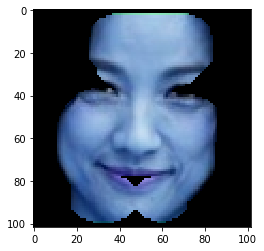

In [146]:
# 피부 검출1
lower = np.array([0, 48, 80], dtype = "uint8")
upper = np.array([20, 255, 255], dtype = "uint8")

converted = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
skinMask = cv2.inRange(converted, lower, upper)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
skinMask = cv2.erode(skinMask, kernel, iterations = 2)
skinMask = cv2.dilate(skinMask, kernel, iterations = 2)

skinMask = cv2.GaussianBlur(skinMask, (3,3), 0)
skin = cv2.bitwise_and(img, img, mask = skinMask)

result = skin
# view_img = np.hstack([img, skin])
plt.imshow(result)
plt.show()
# cv2.imshow("test", view_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

d:\users\yhs\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in ubyte_scalars


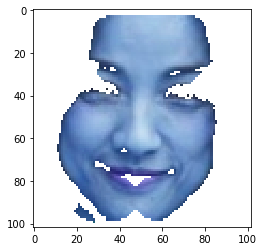

In [147]:
# 피부 검출2
# img = cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)
# plt.imshow(img)
# plt.show()
# img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)


img = cv2.cvtColor(result, cv2.COLOR_BGR2HLS)
skin_img = img
temp_img = cv2.cvtColor(img, cv2.COLOR_HLS2RGB)

h, w, c = img.shape


for i in range(h) :
    for j in range(w) :
        H = img[i][j][0]
        L = img[i][j][1]
        S = img[i][j][2]
        
        R = temp_img[i][j][0]
        G = temp_img[i][j][1]
        B = temp_img[i][j][2]
        
        LS_ratio = L/S
        skin_pixel = bool((S>=50) and (LS_ratio > 0.5) and (LS_ratio < 3.0) and ((H <= 25) or (H >= 165)))
        temp_pixel = bool((R == G) and (G == B) and (R >= 220))
                
        if skin_pixel :
            if temp_pixel :
                skin_img[i][j][0] = 0
                skin_img[i][j][1] = 0
                skin_img[i][j][2] = 0
            else :
                pass
        else :
            skin_img[i][j][0] = 0
            skin_img[i][j][1] = 0
            skin_img[i][j][2] = 0
        
        
        

skin_img = cv2.cvtColor(skin_img, cv2.COLOR_HLS2BGR)            
for i in range(h) :
    for j in range(w) :
        B = skin_img[i][j][0]
        G = skin_img[i][j][1]
        R = skin_img[i][j][2]

        bg_pixel = bool(B==0 and G==0 and R==0)
        
        if bg_pixel :
            skin_img[i][j][0] = 255
            skin_img[i][j][1] = 255
            skin_img[i][j][2] = 255
        else :
            pass
        
        
plt.imshow(skin_img)
plt.show()

# cv2.imshow("Original", img)
# cv2.imshow("Original", skin_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

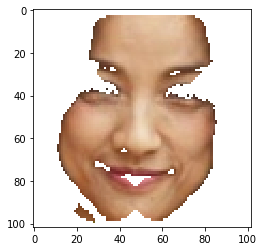

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [148]:
cvt_img = cv2.cvtColor(skin_img, cv2.COLOR_BGR2RGB)
plt.imshow(cvt_img)
plt.show()

cvt_img = cvt_img.reshape((cvt_img.shape[0]*cvt_img.shape[1], 3))
k = 20
clt = KMeans(n_clusters=k)
clt.fit(cvt_img)


In [149]:
def color_ratio(clt) :
    numLabels = np.arange(0, len(np.unique(clt.labels_))+1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist

# k=5이므로 다섯개의 영역에 얼마만큼의 퍼센테이지가 차지되었는지 return된다.

def plot_colors(hist, centroids):
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0

    for (percent, color) in zip(hist, centroids):
#         print("색깔 ",color)
#         print("비율 : ", percent)
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color.astype("uint8").tolist(), -1)
        startX = endX
    return bar

In [150]:
hist = color_ratio(clt)
temp = np.array(clt.cluster_centers_)

# hist에서 높은 값 제거, cluster_centers_에서도 제거)
del_index = hist.argmax()
hist = np.delete(hist, del_index)
temp = np.delete(temp, del_index, 0)

# hist에서 제일 낮은 값 제거, cluster_centers_ 에서도 제거 
del_index = np.argmin(hist)
hist = np.delete(hist, del_index)
temp = np.delete(temp, del_index, 0) 

del_index = np.argmin(hist)
hist = np.delete(hist, del_index)
temp = np.delete(temp, del_index, 0) # 3

del_index = np.argmin(hist)
hist = np.delete(hist, del_index)
temp = np.delete(temp, del_index, 0) # 4

del_index = np.argmin(hist)
hist = np.delete(hist, del_index)
temp = np.delete(temp, del_index, 0) # 5

del_index = np.argmin(hist)
hist = np.delete(hist, del_index)
temp = np.delete(temp, del_index, 0)

del_index = np.argmin(hist)
hist = np.delete(hist, del_index)
temp = np.delete(temp, del_index, 0)

del_index = np.argmin(hist)
hist = np.delete(hist, del_index)
temp = np.delete(temp, del_index, 0)

del_index = np.argmin(hist)
hist = np.delete(hist, del_index)
temp = np.delete(temp, del_index, 0)

del_index = np.argmin(hist)
hist = np.delete(hist, del_index)
temp = np.delete(temp, del_index, 0)

del_index = np.argmin(hist)
hist = np.delete(hist, del_index)
temp = np.delete(temp, del_index, 0)

del_index = np.argmin(hist)
hist = np.delete(hist, del_index)
temp = np.delete(temp, del_index, 0)

del_index = np.argmin(hist)
hist = np.delete(hist, del_index)
temp = np.delete(temp, del_index, 0)

del_index = np.argmin(hist)
hist = np.delete(hist, del_index)
temp = np.delete(temp, del_index, 0)

# 비율 재조정
hist = hist / hist.sum()
####################################

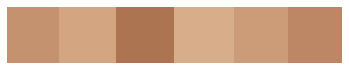

In [151]:
# 그래프 그리기 
bar = plot_colors(hist, temp)

plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()



In [152]:
# RGB변환 후 저장
bar = cv2.cvtColor(bar, cv2.COLOR_BGR2RGB)
cv2.imwrite("img/"+file_name+"_test.jpg", bar)


True